# **Airbnb Price Prediction** 
### Predizer o preço de estadia de locais listados na cidade do Rio de janeiro, no Airbnb.
___

In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sn
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from scipy import stats
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

___
## Importar arquivos

Nesta primeira etapa unificaremos os arquivos contendo informações sobre os locais disponíveis para reserva.<br>
Um arquivo contém poucas colunas, e outro contém um número maior de colunas com informações mais detalhadas.

In [3]:
pd.set_option('display.max_columns', None)

listings_summary = pd.read_csv('listings_summary.csv')
listings_detailed = pd.read_csv('listings_detailed.csv')

print(listings_summary.shape)
print(listings_detailed.shape)

(26615, 16)
(26615, 74)


In [16]:
# Checar se existe coluna no listings_summary que não existe no listings_detailed
dif_columns = [*set(listings_summary.columns) - set(listings_detailed.columns)]
listings_summary[dif_columns].describe().loc['count']

neighbourhood_group    0.0
Name: count, dtype: float64

A unica coluna que existe no arquivo **listings_summary.csv** que não existe no **listings_detailed.csv** é *'neighbourhood_group'*.<br>
Porém é uma coluna vazia. Sendo assim, podemos prosseguir utilizando os dados apenas do arquivo **listings_detailed.csv**.

___
## Tratar dados

In [17]:
df = listings_detailed.copy()

# Remover variáveis que não vão nos ajudar no modelo. Critérios para remoção: 
# - variáveis com informações repetidas
# - variáveis vazias
# - variáveis com informação em texto que não transformaremos em input para o modelo
# - variáveis que obviamente não ajudarão com a predição da variável resposta ('id' por exemplo)
# - variáveis que podem conter informações úteis, porém demandará mais tempo do que o disponível para tratar ('amenities' por exemplo)

df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
             'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
              'host_verifications', 'neighbourhood', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type','bathrooms', 'amenities', 
              'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'license'], axis=1)

# Transformar 'bathrooms_text' em 2 variáveis: uma variável numérica com a quantidade de banheiros, e outra dizendo se o banheiro consta ou não como compartilhado
df['num_bathrooms'] = df['bathrooms_text'].str.replace('[A-z]|-| ','', regex=True)
df['num_bathrooms'] = df['num_bathrooms'].replace(r'^\s*$', np.nan, regex=True).astype(float)
df['shared_bathrooms'] = df['bathrooms_text'].copy()
df['shared_bathrooms'] = df['shared_bathrooms'].apply(lambda x: 't' if 'hared' in str(x) else 'f')
df = df.drop('bathrooms_text', axis=1)

# Agrupar todos os casos que tiverem 5 ou mais banheiros como sendo 5 banheiros
df['num_bathrooms'] = df['num_bathrooms'].map(lambda x: x if (x < 5) else 5)

# Str para Float
df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)
df['price'] = df['price'].str.replace('[$,]','', regex=True).astype(float)
df = df[['price'] + [col for col in df.columns if col != 'price']]



___
## Analisar variável resposta 'price'

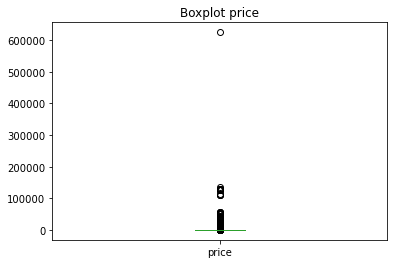

In [6]:
df['price'].sort_values().plot.box()
plt.title('Boxplot price')
plt.show()

**Percebemos acima que temos outliers na variável resposta. Vamos removê-las e ver novamente o boxplot**

Maior valor de preço após retirar valores com mais de 3 desvios padrões da média: 13637.0
Quantidade de linhas removidas (outliers): 89


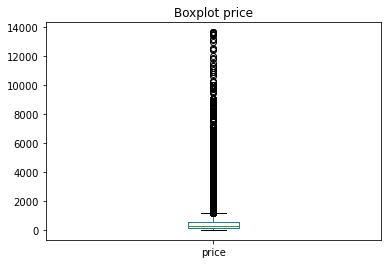

In [7]:
dp = 2.5
print('Maior valor de preço após retirar valores com mais de 3 desvios padrões da média:', df[(np.abs(stats.zscore(df['price'])) < dp)]['price'].max())
print('Quantidade de linhas removidas (outliers):', len(df)-len(df[(np.abs(stats.zscore(df['price'])) < dp)]['price']))

df[(np.abs(stats.zscore(df['price'])) < dp)]['price'].sort_values().plot.box()
plt.title('Boxplot price')
plt.show()

**Detectamos 89 registros com preço acima de 2,5 desvios padrões acima da média, com preços superiores a 13.637,00.<br>
Trabalharemos com a suposição de que esses valores são erros de registro ou são acomodações de alto luxo que estão muito distantes do restante das acomodações.<br>
Para continuarmos nossa análise, removeremos esses 89 outliers, bem como os registros que possuem preço zerado.**

In [18]:
df = df[df['price'] <= df[(np.abs(stats.zscore(df['price'])) < dp)]['price'].max()]
df = df[df['price'] > 0]
df = df.reset_index(drop=True)

___
## Visualizar correlação das variáveis numéricas canditadas a serem explicativas com a variável resposta 'price'

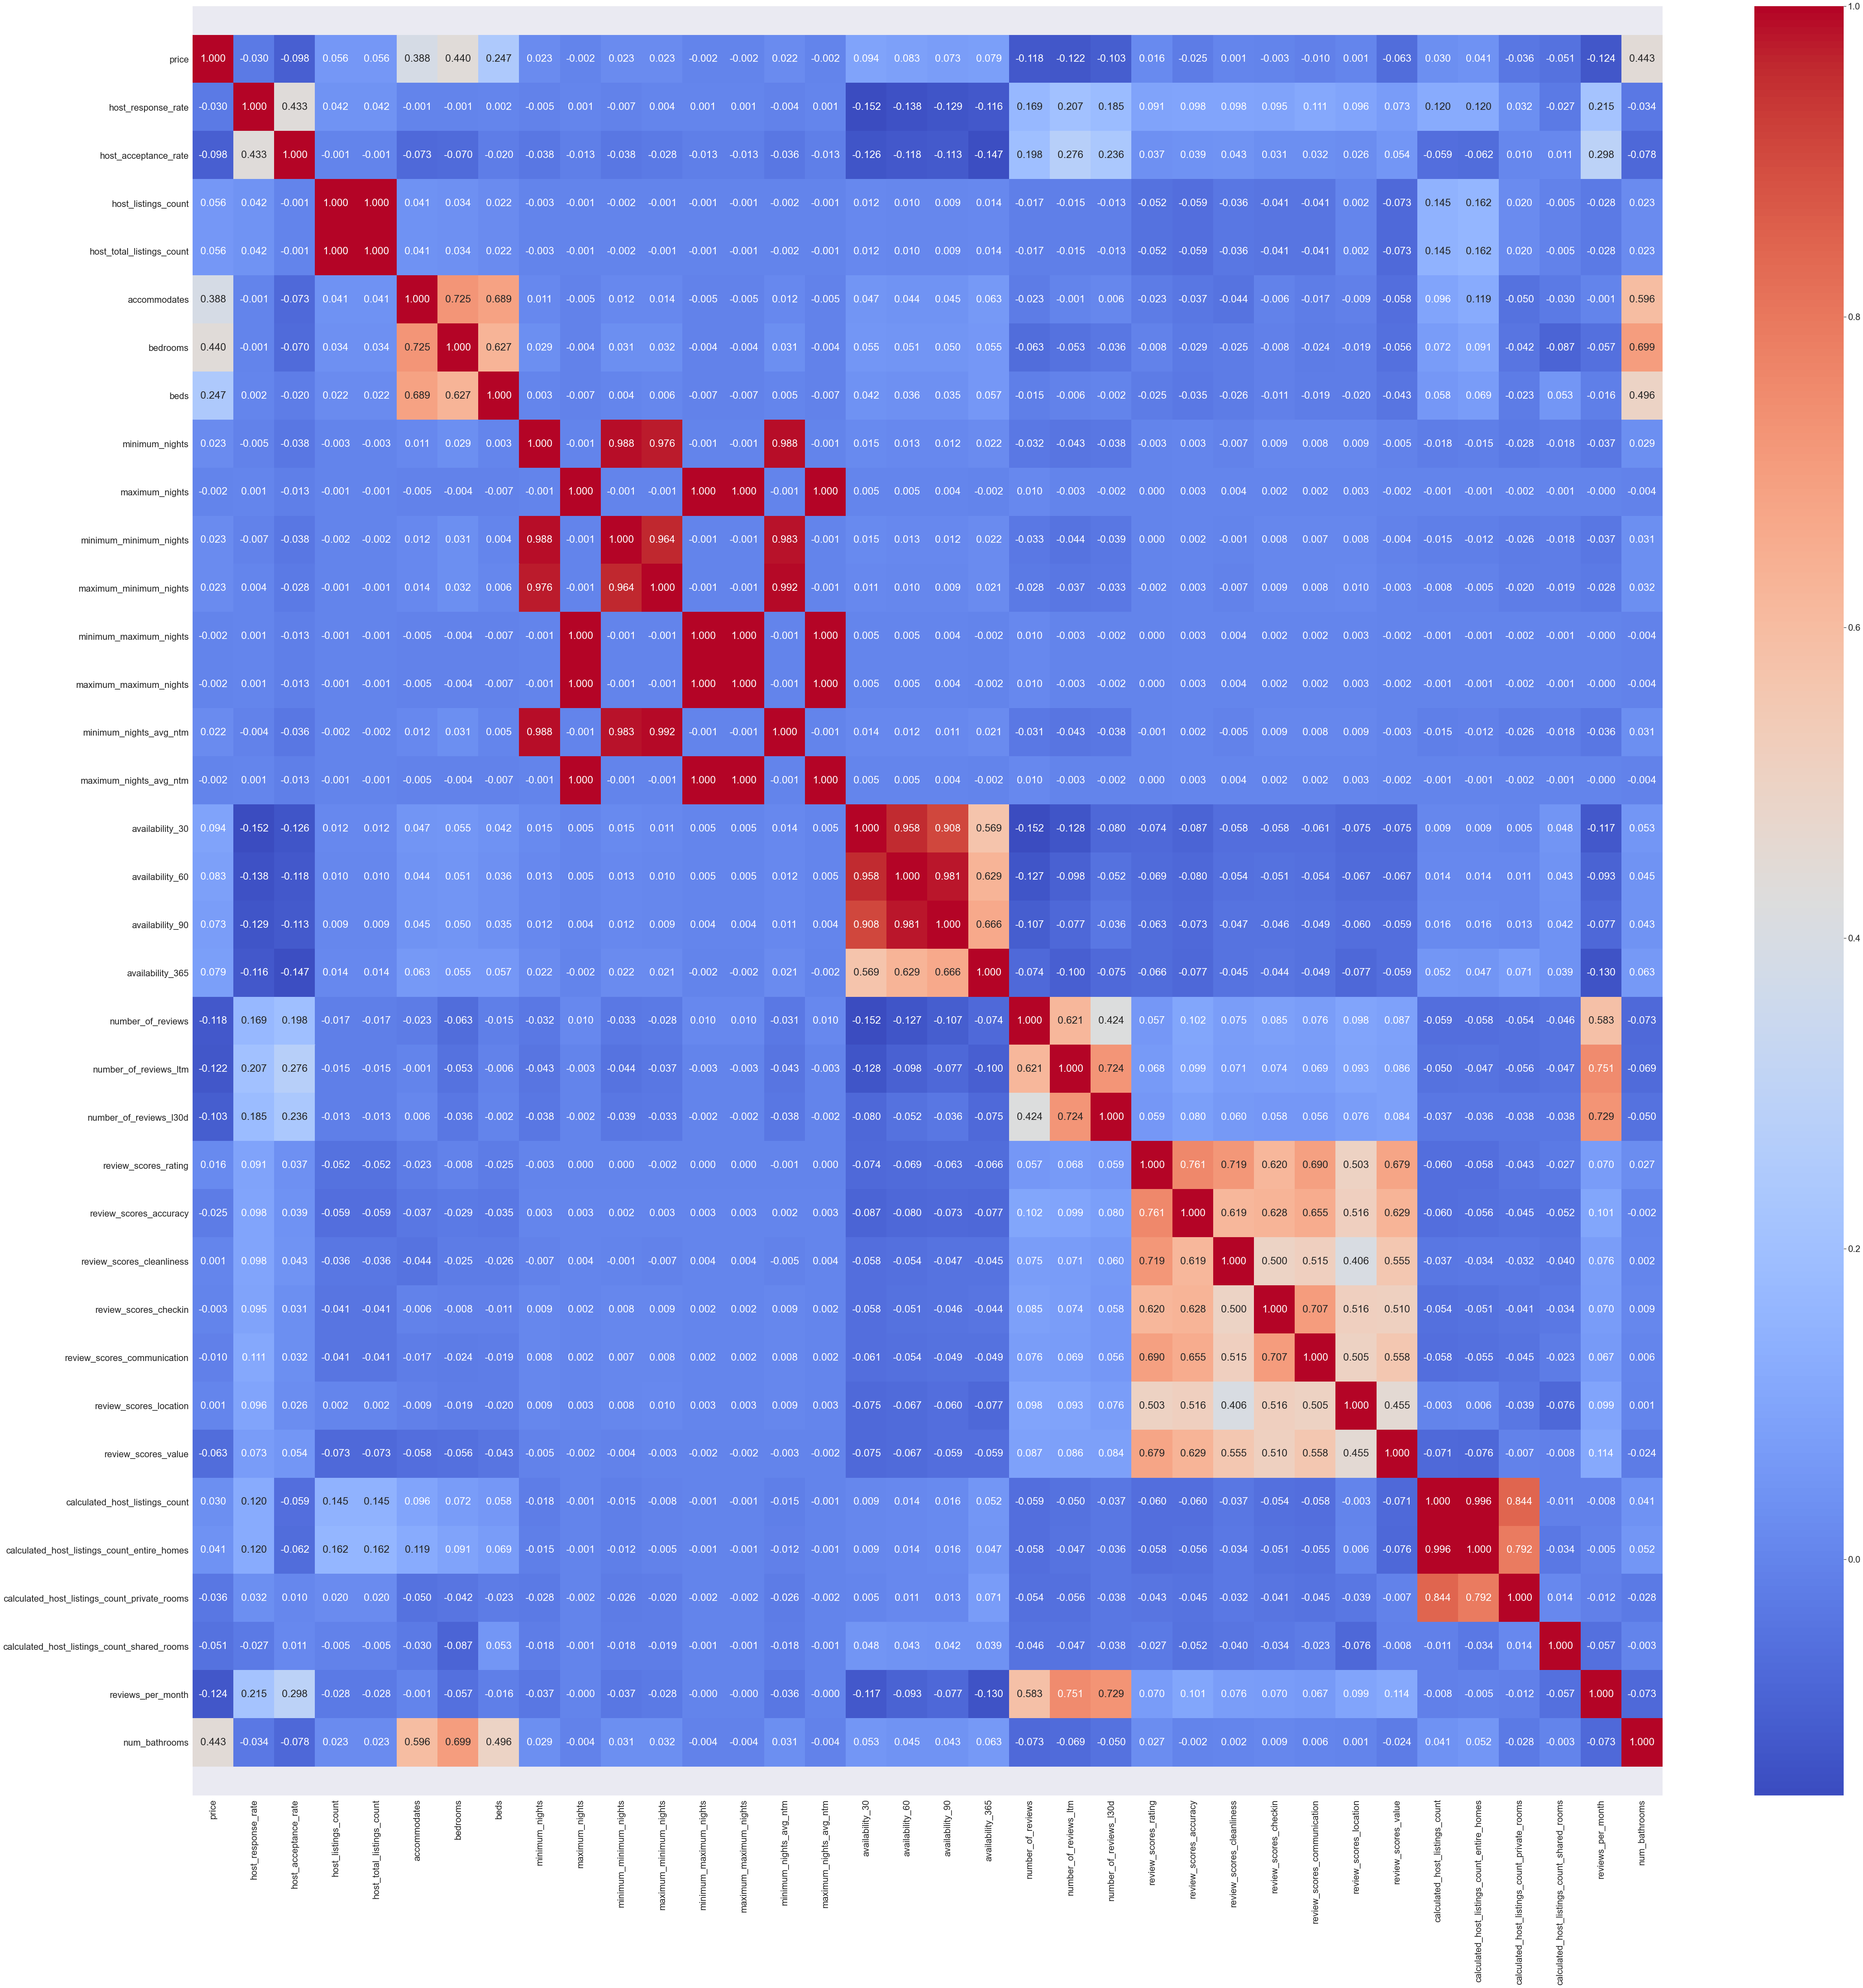

In [9]:
## Matriz de correlação entre variáveis numéricas
sn.set(font_scale=2)
fig, ax = plt.subplots(figsize=(80, 80))
sn.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".3f", annot_kws={'size':25})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.show()

**A maioria das variáveis demonstraram pouca ou nenhuma correlação com o preço. Mas algumas variáveis apresentaram certa correlação com a variável resposta (1 linha do gráfico).<br>
A variável que apresentou maior correlação foi a 'num_bathrooms' que tratamos a partir da varíavel texto disponível no banco de dados original. (última coluna do gráfico).**


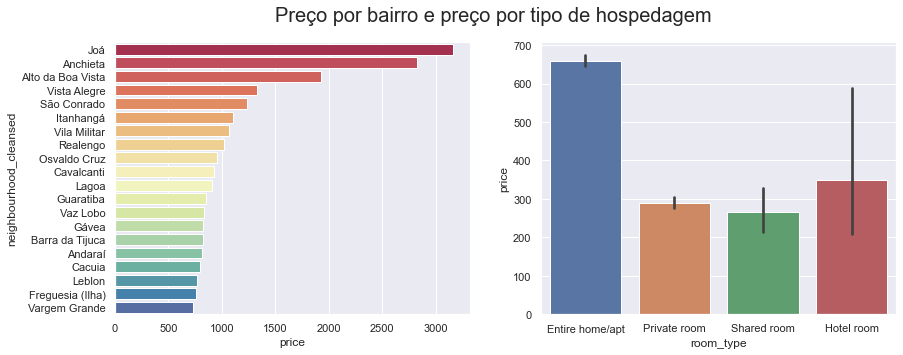

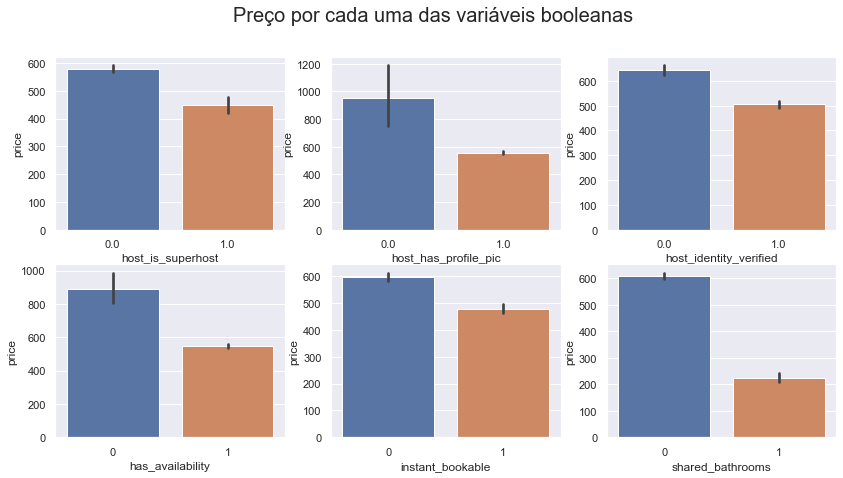

host_is_superhost           0.171202
host_has_profile_pic        0.996679
host_identity_verified      0.630157
has_availability            0.970512
instant_bookable            0.343980
shared_bathrooms            0.132961
price                     557.233116
Name: mean, dtype: float64


In [10]:
# Gráfico de Preço por bairro e preço por tipo de hospedagem
price_por_bairro= df[['price', 'neighbourhood_cleansed']].groupby('neighbourhood_cleansed').mean().sort_values('price', ascending=False).head(20).reset_index()

sn.set(font_scale=1)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,5))
sn.barplot(y="neighbourhood_cleansed", x="price", data=price_por_bairro, ax=axs[0], palette="Spectral")
sn.barplot(x="room_type", y="price", data=df, ax=axs[1])
fig.suptitle('Preço por bairro e preço por tipo de hospedagem', fontsize=20)
plt.show()


# Gráfico de Preço por cada uma das variáveis booleanas
df_bool = df.select_dtypes(include=['object']).drop(['room_type', 'neighbourhood_cleansed'], axis=1)
df_bool['price'] = df['price']
df_bool = df_bool.replace({'t': 1, 'f': 0})

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14,7))
sn.barplot(x="host_is_superhost", y="price", data=df_bool, ax=axs[0,0])
sn.barplot(x="host_has_profile_pic", y="price", data=df_bool, ax=axs[0,1])
sn.barplot(x="host_identity_verified", y="price", data=df_bool, ax=axs[0,2])
sn.barplot(x="has_availability", y="price", data=df_bool, ax=axs[1,0])
sn.barplot(x="instant_bookable", y="price", data=df_bool, ax=axs[1,1])
sn.barplot(x="shared_bathrooms", y="price", data=df_bool, ax=axs[1,2])
fig.suptitle('Preço por cada uma das variáveis booleanas', fontsize=20)
plt.show()

print(df_bool.describe().loc['mean'])

**A variável booleana com maior potencial para ajudar nossa predição de preço é a 'shared_bathrooms'**

___
# Seleção de variáveis

In [ ]:
# Trasformar variável: One-hot Enconding para 'room_type'
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['room_type']]).toarray())
enc_df.columns = enc.get_feature_names(['room_type'])
df = df.join(enc_df)
df = df.drop('room_type', axis=1)

# Trasformar variável: target encoding para 'neighbourhood_cleansed'
encoder = TargetEncoder()
df['neighbourhood_encoded'] = encoder.fit_transform(df['neighbourhood_cleansed'], df['price'])
df = df.drop('neighbourhood_cleansed', axis=1)

# Trasformar variável: 0 ou 1 para variáveis booleanas
var_bool = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable', 'shared_bathrooms']
df_var_bool = df[var_bool].copy()
df_var_bool = df_var_bool.replace({'t':1, 'f':0})
df = df.drop(var_bool, axis=1)

df = df.join(df_var_bool)

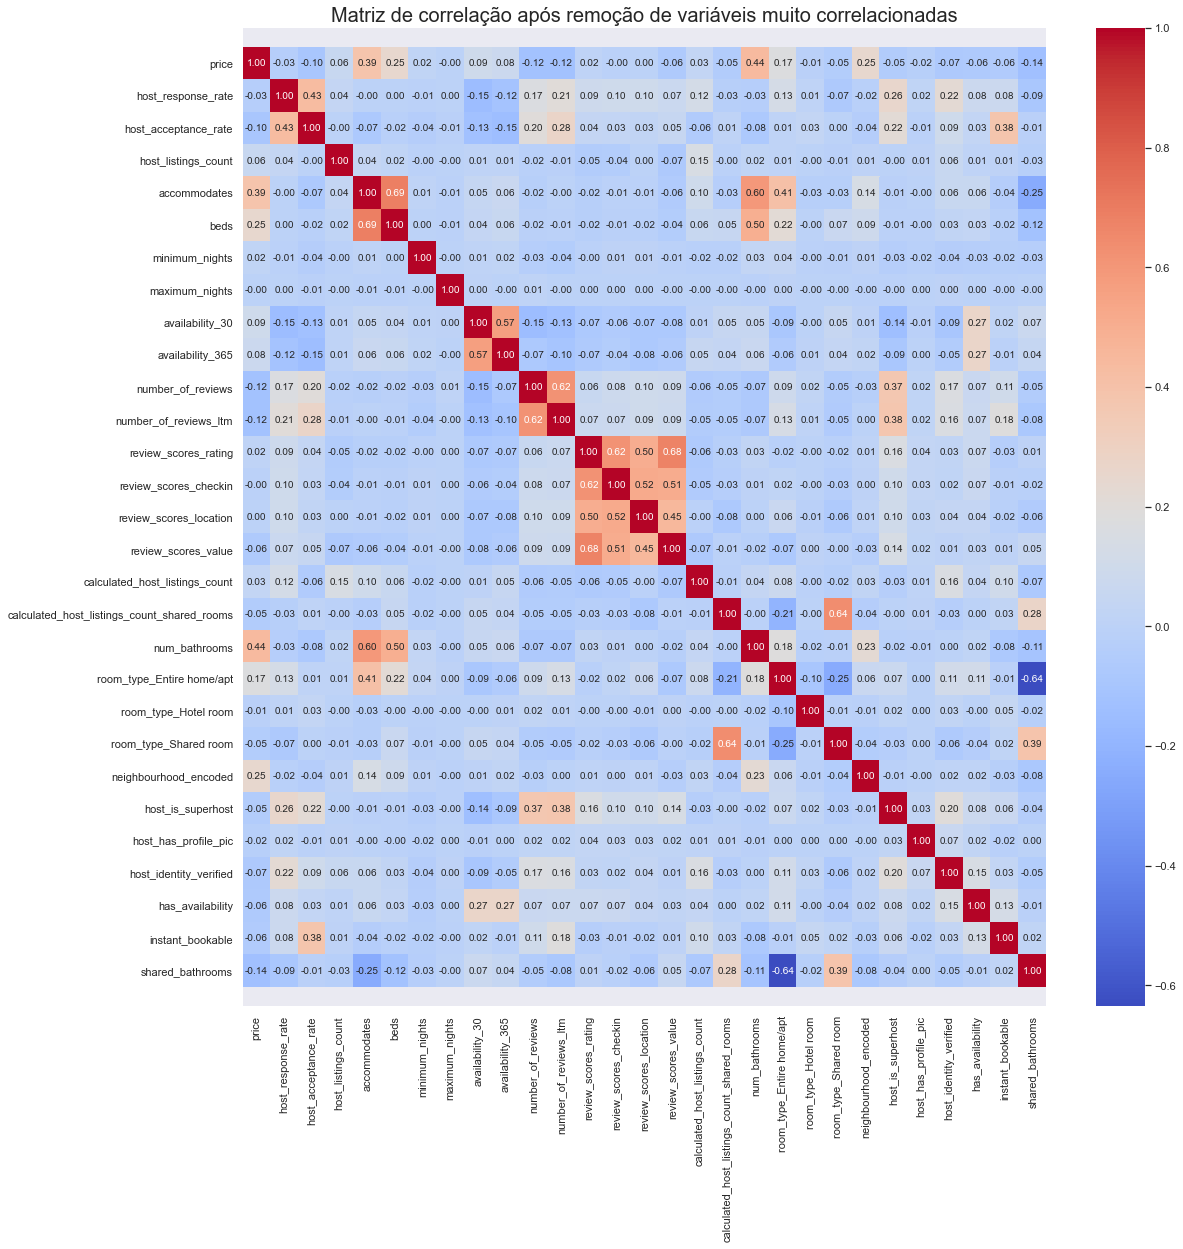

In [21]:
# Criar matriz de correlação com nova a nova lista de variáveis
df_corr = df.drop('price', axis=1).corr().abs()

# Selecionar triangulo superior da matriz de correlação sem a diagional principal
cor_sup = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

# Identificar variáveis com correlação maior do que 0.7 ou menor do que -0.7 (18 variáveis encontradas)
remover = [column for column in cor_sup.columns if any(cor_sup[column] > 0.70)]
remover
# # Remover variáveis
df = df.drop(remover, axis=1).reset_index(drop=True)

# Rever matriz de correlação entre variáveis numéricas
sn.set(font_scale=1)
fig, ax = plt.subplots(figsize=(18, 18))
sn.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size':10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Matriz de correlação após remoção de variáveis muito correlacionadas', fontsize=20)
plt.show()

___
## Criar modelo preditivo inicial

(16972, 28) (16972,)
(4243, 28) (4243,)


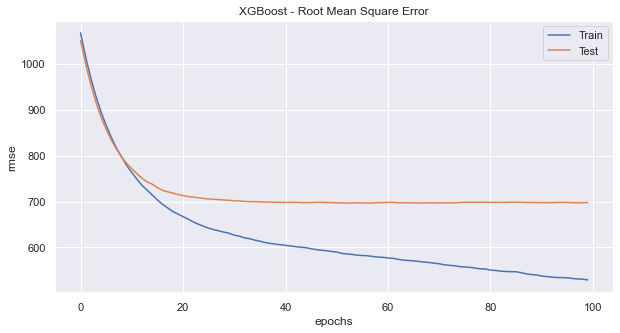


Training r2: 0.71
Validation r2: 0.47
RMSE: 697.84


In [22]:
# Separar 20% do banco para testar modelo no final
df_X, X_test_final, df_y, y_test_final = train_test_split(df.drop(['price'], axis=1), df['price'], test_size=0.2)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# XGBRegressor
eval_set = [(X_train, y_train), (X_test, y_test)]

xgbr = xgb.XGBRegressor(verbosity=0, learning_rate=0.1)
xgbr.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

# plot log loss
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.title('XGBoost - Root Mean Square Error')
plt.show()

ypred_train = xgbr.predict(X_train)
ypred = xgbr.predict(X_test)
print("\nTraining r2:", round(r2_score(y_train, ypred_train),2))
print("Validation r2:", round(r2_score(y_test, ypred),2))

mse = mean_squared_error(y_test, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

___
## Feature Importance

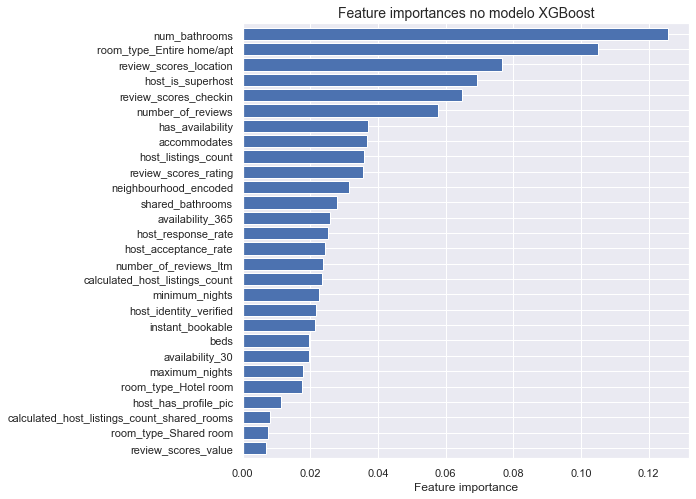

In [23]:
ft_weights_xgb_reg = pd.DataFrame(xgbr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

# Plotting feature importances
plt.figure(figsize=(8,8))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances no modelo XGBoost", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## RandomizedSearchCV

In [ ]:
%%time
fi = ft_weights_xgb_reg.sort_values('weight', ascending=False).index.to_list()
X_train = X_train[fi[:13]]
X_test = X_test[fi[:13]]

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [4,5,6,7]}

# Initialize XGB and GridSearch com as 12 variáveis de maior importância
xgbr = xgb.XGBRegressor(nthread=-1, learning_rate=0.1, n_estimators=50) 
grid = RandomizedSearchCV(xgbr, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, n_iter=100)
grid.fit(X_train, y_train, eval_metric="rmse")

# Print the R² score
print(r2_score(y_test, grid.best_estimator_.predict(X_test))) 
grid.best_params_
# grid.best_estimator_

___
## Ajustar Modelo

In [27]:
### Cross-Validation
xgbr = xgb.XGBRegressor(nthread=-1, learning_rate=0.1, n_estimators=50, subsample=0.7, min_child_weight=4, max_depth=6, gamma=0.3, colsample_bytree=0.9) 

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold , scoring='r2')
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

# Predizer e avaliar com RMSE
eval_set = [(X_train, y_train), (X_test, y_test)]
xgbr.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
# print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

K-fold CV average score: 0.41
RMSE: 713.31


___
## Avaliar Modelo

Avaliação com porção de dados não utilizados para treino nem para ajustes:
RMSE: 672.00
R²: 0.4126


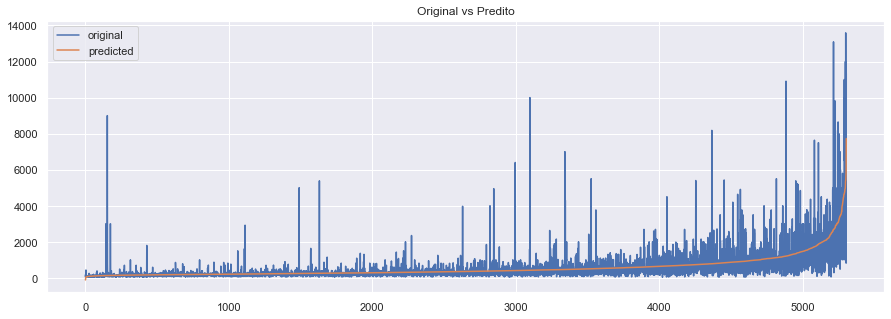

In [28]:
# Predizer e avaliar com RMSE
X_test_final = X_test_final[fi[:13]]

ypred = xgbr.predict(X_test_final)
mse = mean_squared_error(y_test_final, ypred)
print('Avaliação com porção de dados não utilizados para treino nem para ajustes:')
# print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R²:", round(r2_score(y_test_final, ypred),4))

# Visualizar predição vs real
df_test_pred = pd.DataFrame({'y_test_final':y_test_final, 'ypred':ypred})
df_test_pred = df_test_pred.sort_values('ypred')
fig, ax = plt.subplots(figsize=(15, 5))
x_ax = range(len(df_test_pred['y_test_final']))
plt.plot(x_ax, df_test_pred['y_test_final'], label="original")
plt.plot(x_ax, df_test_pred['ypred'], label="predicted")
plt.title("Original vs Predito")
plt.legend()
plt.show()